# 모델 학습 및 평가 보고서

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import matplotlib.font_manager as fm
from pygments.styles.dracula import yellow
from sklearn.cluster import KMeans
from sklearn.datasets import load_breast_cancer, fetch_california_housing, load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor, \
    StackingRegressor, GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, root_mean_squared_error, accuracy_score, f1_score, r2_score, \
    recall_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sympy.abc import alpha

from matplotlib import font_manager as fm, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)
rc('font', family=font_prop.get_name())

plt.rc('axes', unicode_minus=False) # matplotlib이 기본적으로 사용하는 유니코드 마이너스 비활성화, 아스키코드 마이너스 사용)


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 데이터셋 로드

In [2]:
commerce_df = pd.read_csv('data/CommerceData.csv')

## 데이터셋 정보 확인

In [3]:
commerce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

## 데이터셋 통계 확인

In [4]:
commerce_df.describe(include='all')

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630,5630.000000,5379.000000,5630,5630,5375.000000,5630.000000,5630,5630.000000,5630,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
unique,NaN,NaN,NaN,3,NaN,NaN,7,2,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Mobile Phone,NaN,NaN,Debit Card,Male,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2765,NaN,NaN,2314,3384,NaN,NaN,2050,NaN,2986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,52815.500000,0.168384,10.189899,NaN,1.654707,15.639896,NaN,NaN,2.931535,3.688988,NaN,3.066785,NaN,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.221492
std,1625.385339,0.374240,8.557241,NaN,0.915389,8.531475,NaN,NaN,0.721926,1.023999,NaN,1.380194,NaN,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.193869
min,50001.000000,0.000000,0.000000,NaN,1.000000,5.000000,NaN,NaN,0.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,NaN,1.000000,9.000000,NaN,NaN,2.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,0.000000,9.000000,NaN,1.000000,14.000000,NaN,NaN,3.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,0.000000,16.000000,NaN,3.000000,20.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.000000


## 결축치 체크

In [5]:
# 전체 결측치 수 확인
null_df = commerce_df.isnull().sum()

# 1개 이상 결측치가 있는 컬럼만 보기
null_df[null_df > 0]

Tenure                         264
WarehouseToHome                251
HourSpendOnApp                 255
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
dtype: int64

In [6]:
null_df

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

## 데이터 전처리

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 복사본 작업
df = commerce_df.copy()

# 1. 결축치 처리
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median())

df['NoLastYearPurchase'] = df['OrderAmountHikeFromlastYear'].isna().astype(int)
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(0)

df['CouponUsed'] = df['CouponUsed'].fillna(0)
df['OrderCount'] = df['OrderCount'].fillna(0)

df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median())

# 2. 범주형 인코딩 (One-Hot Encoder 사용)
cat_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
            'PreferedOrderCat', 'MaritalStatus']

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 3. ID 제거
df.drop(columns=['CustomerID'], inplace=True)


In [12]:
df.head()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,4.0,3,6.0,3.0,3,2,9,1,11.0,...,False,False,False,False,True,False,False,False,False,True
1,1,9.0,1,8.0,3.0,4,3,7,1,15.0,...,False,True,True,False,False,True,False,False,False,True
2,1,9.0,1,30.0,2.0,4,3,6,1,14.0,...,False,False,True,False,False,True,False,False,False,True
3,1,0.0,3,15.0,2.0,4,5,8,0,23.0,...,False,False,True,False,True,False,False,False,False,True
4,1,0.0,1,12.0,3.0,3,5,3,0,11.0,...,False,False,True,False,False,True,False,False,False,True


## 학습, 평가셋 분리 & 스케일링 진행

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. train/test 분리 (스케일링 전에 분리)
X = df.drop(columns='Churn')
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. 연속형 변수만 선택하기 위해서 제외할 컬럼 리스트 정의
exclude = ['CityTier', 'PreferredPaymentMode', 'Gender',
           'PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice']

# 정수형, 실수형 컬럼 중에서 exclude 컬럼 제외한 컬럼 뽑기
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.difference(exclude)

# 3. 스케일러 선언 및 학습
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [6]:
# streamlit에서 예측 시 사용하기 위해 scaler 저장
import joblib

joblib.dump(scaler, '../03_trained_model/train_scaler.pkl')

['../03_trained_model/train_scaler.pkl']

## 모델별 학습, 평가 진행

## RandomForest

In [7]:
# RandomForest 기본 버전

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("RandomForest (Standard Scaling)")
print(f"test accuracy: {rf.score(X_test, y_test)}")
print(f"train accuracy: {rf.score(X_train, y_train)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

RandomForest (Standard Scaling)
test accuracy: 0.9795737122557726
train accuracy: 1.0
f1 score: 0.9362880886426593
양성 클래스 recall: 0.8894736842105263
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       936
           1       0.99      0.89      0.94       190

    accuracy                           0.98      1126
   macro avg       0.98      0.94      0.96      1126
weighted avg       0.98      0.98      0.98      1126



In [8]:
# RandomForest 양성 클래스에 대한 재현율 1로 높이기 위해서 threshold 지정한 버전
# 이탈 확률이 조금이라도 있는 고객을 식별하기 위함.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
# 양성 클래스 recall 점수가 1이면서 정확도가 가장 높았던 threshold = 0.285
threshold = 0.225
y_pred1 = (y_pred_proba > threshold).astype(int)

print("RandomForest (Standard Scaling)")
print(f"accuracy: {accuracy_score(y_test, y_pred1)}")
print(f"f1 score: {f1_score(y_test, y_pred1)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred1)}")
print(classification_report(y_test, y_pred1)) # 양성 클래스 precision이 0.87로 조금 아쉬움. (양성 클래스라고 예측한 것 중, 실제 양성 클래스인 확률)

RandomForest (Standard Scaling)
accuracy: 0.9529307282415631
f1 score: 0.8775981524249422
양성 클래스 recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       936
           1       0.78      1.00      0.88       190

    accuracy                           0.95      1126
   macro avg       0.89      0.97      0.92      1126
weighted avg       0.96      0.95      0.96      1126



In [9]:
joblib.dump(rf, '../03_trained_model/random_forest_model(threshold=0.225).pkl')

['../03_trained_model/random_forest_model(threshold=0.225).pkl']

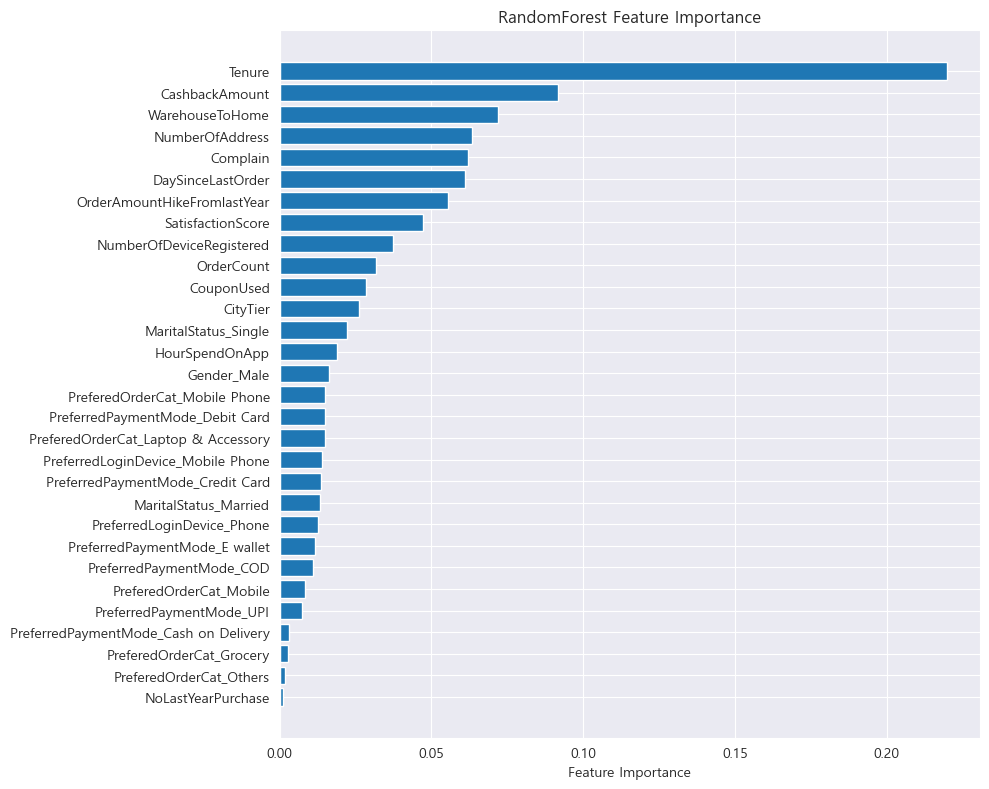

In [10]:
# RandomForest 모델의 예측 - 특성별 중요도

# 특성 이름과 중요도 추출
importances = rf.feature_importances_
features = X_train.columns

# 중요도 순 정렬
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("RandomForest Feature Importance")
plt.tight_layout()
plt.show()

## xgboost

In [11]:
# xgboost 기본 버전

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# XGBoost 모델 선언
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# 학습
xgb.fit(X_train, y_train)

# 예측
y_pred = xgb.predict(X_test)

# 결과 출력
print("📊 XGBoost (Standard Scaling)")
print(f"accuracy: {xgb.score(X_test, y_test)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

📊 XGBoost (Standard Scaling)
accuracy: 0.9857904085257548
f1 score: 0.956989247311828
양성 클래스 recall: 0.9368421052631579
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       936
           1       0.98      0.94      0.96       190

    accuracy                           0.99      1126
   macro avg       0.98      0.97      0.97      1126
weighted avg       0.99      0.99      0.99      1126



In [12]:
# 예측
y_pred = xgb.predict(X_test)
threshold = 0.075
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
y_pred1 = (y_pred_proba > threshold).astype(int)

# 결과 출력
print("📊 XGBoost (Standard Scaling)")
print(f"accuracy: {accuracy_score(y_test, y_pred1)}")
print(f"f1 score: {f1_score(y_test, y_pred1)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred1)}")
print(classification_report(y_test, y_pred1)) # random forest에서 threshold 지정했을때보다는 그래도 양성 클래스에 대한 precision이 0.92로 높은편

📊 XGBoost (Standard Scaling)
accuracy: 0.9626998223801065
f1 score: 0.9004739336492891
양성 클래스 recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       936
           1       0.82      1.00      0.90       190

    accuracy                           0.96      1126
   macro avg       0.91      0.98      0.94      1126
weighted avg       0.97      0.96      0.96      1126



In [13]:
joblib.dump(xgb, '../03_trained_model/xgboost_model(threshold=0.075).pkl')

['../03_trained_model/xgboost_model(threshold=0.075).pkl']

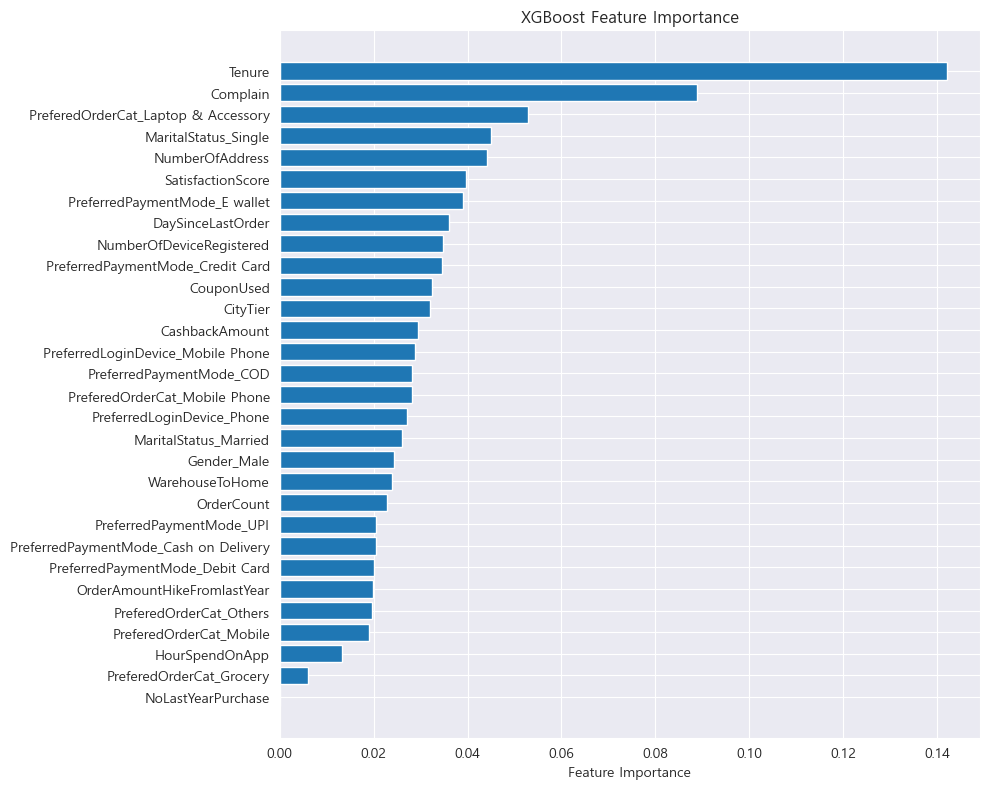

In [14]:
# XGBoost 모델의 예측 - 특성별 중요도

# 특성 이름과 중요도 추출
importances = xgb.feature_importances_
features = X_train.columns

# 중요도 순 정렬
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

## KNC

In [15]:
# knc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# for문 안에서 knc 모델 선언

for i in range(5,56,10): # knc는 n_neighbors수에 민감한 모델이기 때문에, 5개 정도만 테스트
    knc = KNeighborsClassifier(n_neighbors=i)

    # 학습
    knc.fit(X_train, y_train)

    # 예측
    y_pred = knc.predict(X_test)

    # 결과 출력
    print(f"📊 knc (Standard Scaling) - neighbors:{i}")
    print(classification_report(y_test, y_pred))

📊 knc (Standard Scaling) - neighbors:5
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       936
           1       0.82      0.59      0.69       190

    accuracy                           0.91      1126
   macro avg       0.87      0.78      0.82      1126
weighted avg       0.90      0.91      0.90      1126

📊 knc (Standard Scaling) - neighbors:15
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       936
           1       0.77      0.35      0.48       190

    accuracy                           0.87      1126
   macro avg       0.82      0.66      0.70      1126
weighted avg       0.86      0.87      0.85      1126

📊 knc (Standard Scaling) - neighbors:25
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       936
           1       0.76      0.28      0.41       190

    accuracy                           0.86      1126
   macro 

In [16]:
# knc 양성 클래스 재현율 높인 버전 (neighbors 수는 정확도가 그나마 높은 5로 고정)

# knc 모델 선언

knc = KNeighborsClassifier(n_neighbors=5)

# 학습
knc.fit(X_train, y_train)

# 예측
y_pred = knc.predict(X_test)

threshold = 0.003 # 이정도로 낮춰도 양성 클래스 recall이 1이 되지 않음.
y_pred_proba = knc.predict_proba(X_test)[:, 1]
y_pred1 = (y_pred_proba > threshold).astype(int)

# 결과 출력
print("📊 knc (Standard Scaling)")
print(classification_report(y_test, y_pred1))

📊 knc (Standard Scaling)
              precision    recall  f1-score   support

           0       0.99      0.78      0.88       936
           1       0.48      0.97      0.64       190

    accuracy                           0.81      1126
   macro avg       0.73      0.88      0.76      1126
weighted avg       0.90      0.81      0.84      1126



In [17]:
joblib.dump(knc, '../03_trained_model/knc_model(threshold=0.003).pkl')

['../03_trained_model/knc_model(threshold=0.003).pkl']

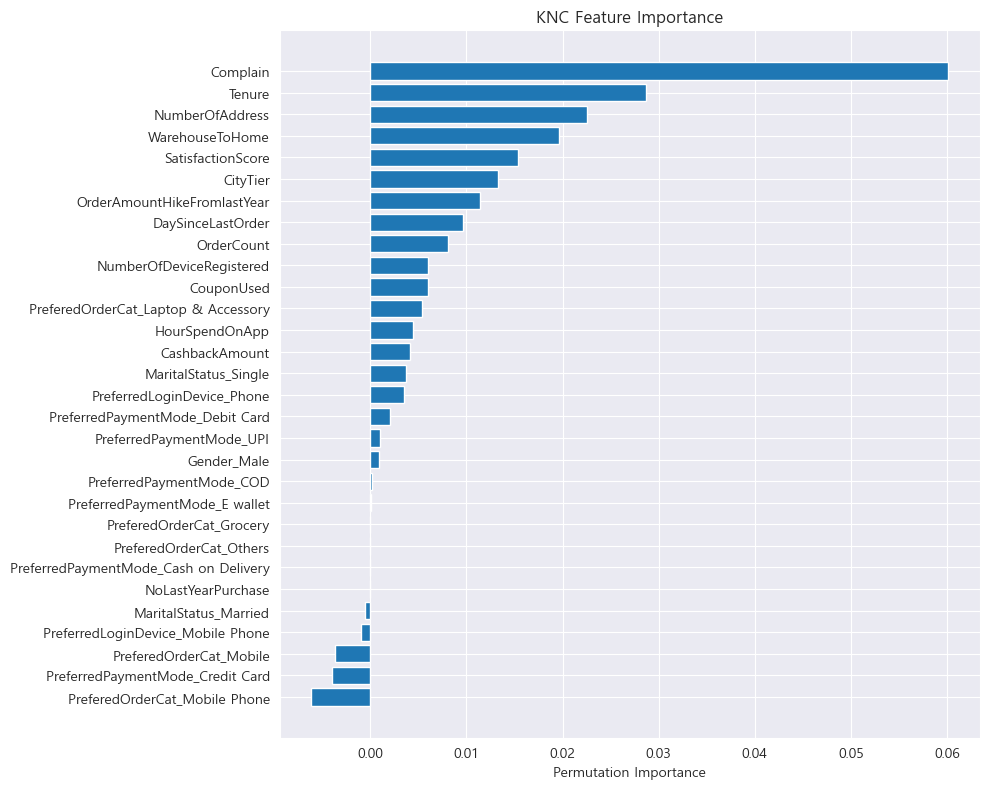

In [18]:
from sklearn.inspection import permutation_importance
# permutation importance 계산
result = permutation_importance(
    knc, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 특성 중요도 정렬
importances = result.importances_mean
indices = np.argsort(importances)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel("Permutation Importance")
plt.title("KNC Feature Importance")
plt.tight_layout()
plt.show()

## SVC

In [19]:
# svc 기본

from sklearn.svm import SVC
from sklearn.metrics import classification_report

# svc 모델 선언

for i in ['linear', 'rbf']: # 커널 정도만 테스트
    svc = SVC(kernel=i, random_state=42, probability=True)

    # 학습
    svc.fit(X_train, y_train)

    # 예측
    y_pred = svc.predict(X_test)

    # 결과 출력
    print(f"📊 SVC (Standard Scaling) - kernel: {i}")
    print(classification_report(y_test, y_pred))

📊 SVC (Standard Scaling) - kernel: linear
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       936
           1       0.76      0.54      0.63       190

    accuracy                           0.89      1126
   macro avg       0.83      0.75      0.78      1126
weighted avg       0.88      0.89      0.88      1126

📊 SVC (Standard Scaling) - kernel: rbf
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       936
           1       0.87      0.51      0.64       190

    accuracy                           0.90      1126
   macro avg       0.89      0.75      0.79      1126
weighted avg       0.90      0.90      0.89      1126



In [20]:
# svc 모델로 양성 클래스 재현율 높인 버전
# 기본 버전에서 그나마 accuracy 높았던 rbf kernal로 고정

from sklearn.svm import SVC
from sklearn.metrics import classification_report

# svc 모델 선언

svc = SVC(kernel='rbf', random_state=42, probability=True)

# 학습
svc.fit(X_train, y_train)

# 예측
y_pred = svc.predict(X_test)

threshold = 0.025 # 이정도 낮춰도 양성 클래스 recall 점수가 0.97까지 밖에 안 올라감.
y_pred_proba = svc.predict_proba(X_test)[:, 1]
y_pred1 = (y_pred_proba > threshold).astype(int)

# 결과 출력
print("📊 SVC (Standard Scaling) - rbf")
print(classification_report(y_test, y_pred1))

📊 SVC (Standard Scaling) - rbf
              precision    recall  f1-score   support

           0       0.98      0.35      0.52       936
           1       0.23      0.96      0.37       190

    accuracy                           0.45      1126
   macro avg       0.60      0.65      0.44      1126
weighted avg       0.85      0.45      0.49      1126



In [21]:
joblib.dump(svc, '../03_trained_model/svc_model(threshold=0.025).pkl')

['../03_trained_model/svc_model(threshold=0.025).pkl']

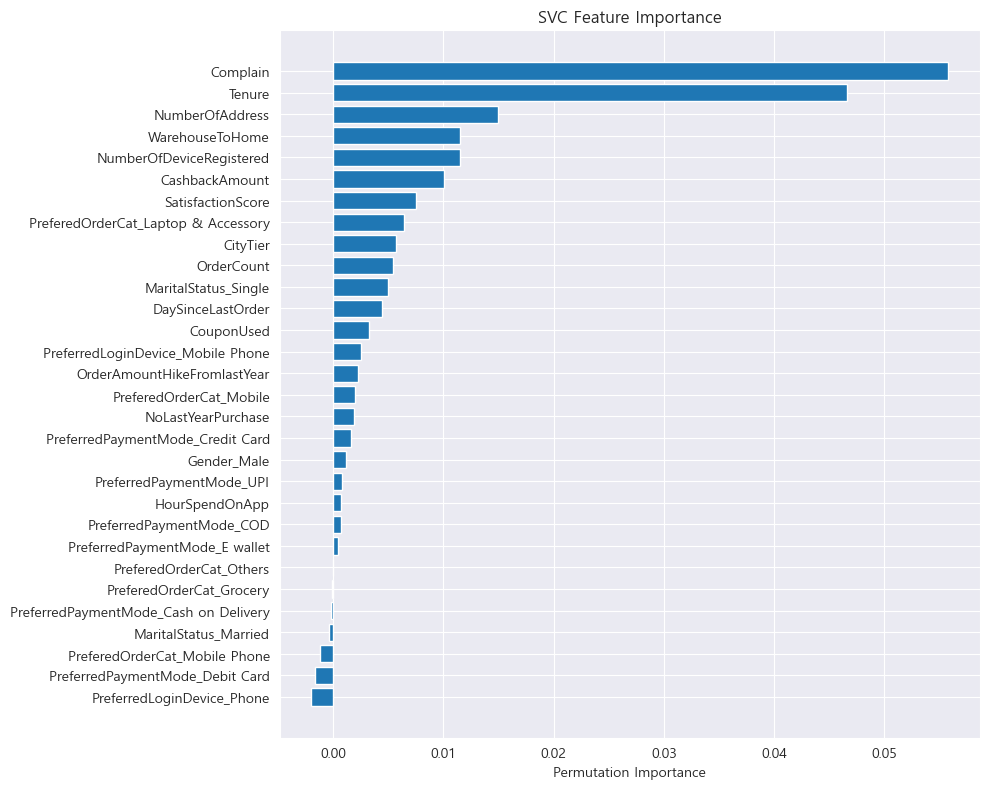

In [22]:
# permutation importance 계산
result = permutation_importance(
    svc, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 특성 중요도 정렬
importances = result.importances_mean
indices = np.argsort(importances)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel("Permutation Importance")
plt.title("SVC Feature Importance")
plt.tight_layout()
plt.show()

## HistGradientBoosting

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier(
    random_state=42,
    max_iter=5000, # 약 학습기의 개수 지정
    verbose=2
)

hgb_clf.fit(X_train, y_train)
y_pred = hgb_clf.predict(X_test)
y_pred_proba = hgb_clf.predict_proba(X_test)[:, 1]

print(f"test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))



Binning 0.001 GB of training data: 0.020 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 31 leaves, max depth = 8, in 0.008s
[2/5000] 1 tree, 31 leaves, max depth = 9, in 0.007s
[3/5000] 1 tree, 31 leaves, max depth = 9, in 0.003s
[4/5000] 1 tree, 31 leaves, max depth = 9, in 0.003s
[5/5000] 1 tree, 31 leaves, max depth = 8, in 0.004s
[6/5000] 1 tree, 31 leaves, max depth = 10, in 0.003s
[7/5000] 1 tree, 31 leaves, max depth = 10, in 0.003s
[8/5000] 1 tree, 31 leaves, max depth = 9, in 0.004s
[9/5000] 1 tree, 31 leaves, max depth = 10, in 0.005s
[10/5000] 1 tree, 31 leaves, max depth = 11, in 0.004s
[11/5000] 1 tree, 31 leaves, max depth = 10, in 0.005s
[12/5000] 1 tree, 31 leaves, max depth = 9, in 0.004s
[13/5000] 1 tree, 31 leaves, max depth = 9, in 0.004s
[14/5000] 1 tree, 31 leaves, max depth = 10, in 0.003s
[15/5000] 1 tree, 31 leaves, max depth = 11, in 0.003s
[16/5000] 1 tree, 31 leaves, max depth = 10, in 0.004s
[17/5000] 1 tree, 31 leaves, max depth = 9, in 0.004s
[18/500

In [24]:
# hist 모델에서 threshold 지정 버전

threshold = 0.0001
y_pred = (y_pred_proba > threshold).astype(int)

print(f"test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

test accuracy: 0.9795737122557726
f1 score: 0.9429280397022333
양성 클래스 recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       936
           1       0.89      1.00      0.94       190

    accuracy                           0.98      1126
   macro avg       0.95      0.99      0.97      1126
weighted avg       0.98      0.98      0.98      1126



In [25]:
joblib.dump(hgb_clf, '../03_trained_model/hgb_model(threshold=0.0001).pkl')

['../03_trained_model/hgb_model(threshold=0.0001).pkl']

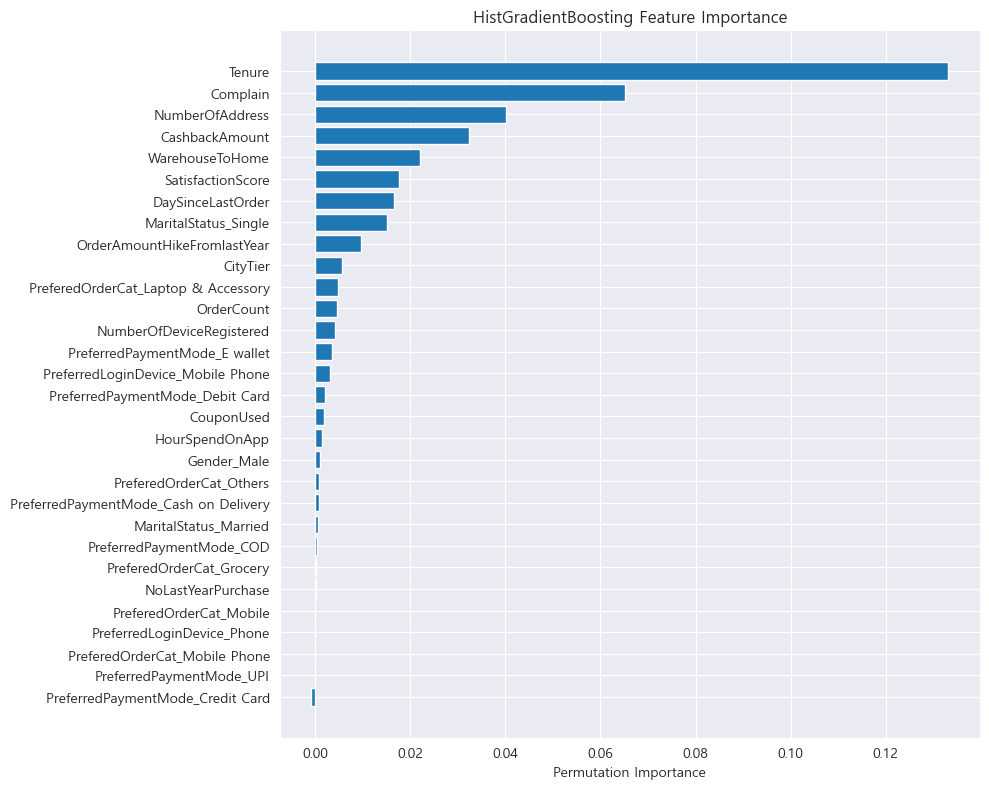

In [26]:
# permutation importance로 특성 중요도 판단

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# permutation importance 계산
result = permutation_importance(
    hgb_clf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 특성 중요도 정렬
importances = result.importances_mean
indices = np.argsort(importances)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel("Permutation Importance")
plt.title("HistGradientBoosting Feature Importance")
plt.tight_layout()
plt.show()

## Stacking

In [27]:
# stacking 모델
# 점수가 높았던 RandomForest와 XGB를 BASE 모델로 사용
# LogisticRegression 모델을 최종 예측 모델로 설정

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# 베이스 모델 정의
estimators = [
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('rf', RandomForestClassifier(random_state=42))
]

# 스태킹 모델 정의 (메타 모델: 로지스틱 회귀)
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=False,  # 원본 특성도 함께 전달
    cv=5,
    n_jobs=-1
)

# 학습
stack_model.fit(X_train, y_train)

# 예측
y_pred = stack_model.predict(X_test)

# 평가
print("📊 Stacking Model (XGBoost + RandomForest)")
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

📊 Stacking Model (XGBoost + RandomForest)
test accuracy: 0.9884547069271759
f1 score: 0.9653333333333334
양성 클래스 recall: 0.9526315789473684
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       936
           1       0.98      0.95      0.97       190

    accuracy                           0.99      1126
   macro avg       0.98      0.97      0.98      1126
weighted avg       0.99      0.99      0.99      1126



In [28]:
# stacking 모델에서 threshold 지정 버전

threshold = 0.091
y_pred_proba = stack_model.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba > threshold).astype(int)

# 평가
print("📊 Stacking Model (XGBoost + RandomForest)")
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

📊 Stacking Model (XGBoost + RandomForest)
test accuracy: 0.9733570159857904
f1 score: 0.926829268292683
양성 클래스 recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       936
           1       0.86      1.00      0.93       190

    accuracy                           0.97      1126
   macro avg       0.93      0.98      0.96      1126
weighted avg       0.98      0.97      0.97      1126



In [29]:
joblib.dump(stack_model, '../03_trained_model/stack_model(threshold=0.091).pkl')

['../03_trained_model/stack_model(threshold=0.091).pkl']

## Voting 모델

In [30]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

# 1. 모델 정의
voting_model = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(random_state=42, eval_metric='logloss')),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='soft',  # 확률 기반으로 투표
    n_jobs=-1
)

# 2. 학습
voting_model.fit(X_train, y_train)

# 3. 예측
y_pred = voting_model.predict(X_test)

# 4. 평가
print("📊 Voting Model (XGBoost + RandomForest)")
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

📊 Voting Model (XGBoost + RandomForest)
test accuracy: 0.9849023090586145
f1 score: 0.9539295392953929
양성 클래스 recall: 0.9263157894736842
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       936
           1       0.98      0.93      0.95       190

    accuracy                           0.98      1126
   macro avg       0.98      0.96      0.97      1126
weighted avg       0.98      0.98      0.98      1126



In [31]:
# voting 모델에서 threshold 지정 버전

# 3. 예측
threshold = 0.1925
y_pred_proba = voting_model.predict_proba(X_test)[:, 1]  # 클래스 1 확률
y_pred = (y_pred_proba > threshold).astype(int)

# 4. 평가
print("📊 Voting Model (XGBoost + RandomForest)")
print(f"test accuracy: {accuracy_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

📊 Voting Model (XGBoost + RandomForest)
test accuracy: 0.9715808170515098
f1 score: 0.9223300970873787
양성 클래스 recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       936
           1       0.86      1.00      0.92       190

    accuracy                           0.97      1126
   macro avg       0.93      0.98      0.95      1126
weighted avg       0.98      0.97      0.97      1126



In [32]:
joblib.dump(voting_model, '../03_trained_model/voting_model(threshold=0.1925).pkl')

['../03_trained_model/voting_model(threshold=0.1925).pkl']

## LGB

In [33]:
# LGB 기본 & threshold 지정 버전

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

# 1. 모델 선언
lgbm = LGBMClassifier(random_state=42)

# 2. 모델 학습
lgbm.fit(X_train, y_train)

# 3. 기본 예측 (threshold = 0.5)
y_pred = lgbm.predict(X_test)
print("📊 LightGBM (Default Threshold)")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# 4. threshold 조정
threshold = 0.147
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_pred_proba > threshold).astype(int)

print("\n📊 LightGBM (Adjusted Threshold)")
print(f"accuracy: {accuracy_score(y_test, y_pred_thresh)}")
print(f"f1 score: {f1_score(y_test, y_pred_thresh)}")
print(f"양성 클래스 recall: {recall_score(y_test, y_pred_thresh)}")
print(classification_report(y_test, y_pred_thresh))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 758, number of negative: 3746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 4504, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168295 -> initscore=-1.597760
[LightGBM] [Info] Start training from score -1.597760
📊 LightGBM (Default Threshold)
accuracy: 0.9813499111900533
f1 score: 0.9421487603305785
양성 클래스 recall: 0.9
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       936
           1       0.99      0.90      0.94       190

    accuracy                           0.98      1126
   macro avg       0.98      0.95      0.

In [34]:
joblib.dump(lgbm, '../03_trained_model/lgbm(threshold=0.147).pkl')

['../03_trained_model/lgbm(threshold=0.147).pkl']

## Gradient Boosting

In [35]:
# Gradient Boosting 기본

from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42, max_depth=7, n_estimators= 119)

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
gb_clf.score(X_test, y_test)
print(f"test accuracy score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

test accuracy score: 0.9911190053285968
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       936
           1       0.98      0.96      0.97       190

    accuracy                           0.99      1126
   macro avg       0.99      0.98      0.98      1126
weighted avg       0.99      0.99      0.99      1126



### 최고점수 : gradient boosting (threshold 지정 버전)

In [36]:
# Gradient Boosting - threshold 지정 버전

gb_clf = GradientBoostingClassifier(random_state=42, max_depth=7, n_estimators= 119)

gb_clf.fit(X_train, y_train)

threshold = 0.1375
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > threshold).astype(int)

print(f"accuracy score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

accuracy score: 0.9937833037300178
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       936
           1       0.96      1.00      0.98       190

    accuracy                           0.99      1126
   macro avg       0.98      1.00      0.99      1126
weighted avg       0.99      0.99      0.99      1126



In [37]:
joblib.dump(gb_clf, '../03_trained_model/gb_model(threshold=0.1375).pkl')

['../03_trained_model/gb_model(threshold=0.1375).pkl']

## 최고점수 모델 기준으로 전체 데이터 예측

### Clustering 이후 rfm 분석을 위함

In [38]:
X2 = X.copy()

X2[num_cols] = scaler.transform(X2[num_cols])

y_pred_proba = gb_clf.predict_proba(X2)[:, 1]
y_pred = (y_pred_proba > threshold).astype(int)

print(accuracy_score(y, y_pred))

X2['model pred'] = y_pred
X2['model pred proba'] = y_pred_proba
X2['actual churn'] = y

X2.head()

0.9987566607460036


,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,model pred,model pred proba,actual churn
0,-0.734332,3,-1.163966,0.091233,-0.675976,-0.771089,1.872534,1.602791,-0.818855,-0.356781,...,False,True,False,False,False,False,True,1,0.962700,1
1,-0.135398,1,-0.922538,0.091233,0.294877,-0.048604,1.092737,1.602791,0.001822,-0.887474,...,False,False,True,False,False,False,True,1,0.988024,1
2,-0.135398,1,1.733179,-1.325711,0.294877,-0.048604,0.702839,1.602791,-0.203347,-0.887474,...,False,False,True,False,False,False,True,1,0.995462,1
3,-1.213479,3,-0.077537,-1.325711,0.294877,1.396365,1.482635,-0.623912,1.643175,-0.887474,...,False,True,False,False,False,False,True,1,0.991073,1
4,-1.213479,1,-0.439680,0.091233,-0.675976,1.396365,-0.466857,-0.623912,-0.818855,-0.356781,...,False,False,True,False,False,False,True,1,0.958252,1


### rfm_df 생성

In [39]:
rfm_df = df[['DaySinceLastOrder', 'OrderCount', 'CashbackAmount']].copy()

rfm_df.columns = ['recency', 'frequency', 'monetary']

scaler1 = StandardScaler()
rfm_scaled = scaler1.fit_transform(rfm_df)

rfm_scaled

array([[ 0.15143648, -0.63624858, -0.35010504],
       [-1.24900275, -0.63624858, -1.14295718],
       [-0.40873921, -0.63624858, -1.16328672],
       ...,
       [-0.12865136, -0.29603778,  0.17846305],
       [ 1.27178787, -0.29603778,  0.03615625],
       [-0.40873921, -0.29603778, -0.16713917]], shape=(5630, 3))

## rfm_df로 Clustering(군집화) 진행

### Inertia와 Silhouette 최적화 시키는 k=6 기준으로 kmeans 군집화 진행

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)

kmeans.fit(rfm_scaled)


rfm_df['cluster'] = kmeans.predict(rfm_scaled)

rfm_df['model_pred_proba'] = X2['model pred proba'] # 모델이 예측한 양성 클래스 확률값


# cluster별 rfm + 이탈확률 체크

rfm_df.groupby('cluster')[['recency','frequency','monetary', 'model_pred_proba']].mean().round(4)

,recency,frequency,monetary,model_pred_proba
cluster,,,,
0,2.1462,1.6979,149.4059,0.2215
1,8.0597,1.9967,167.0122,0.0912
2,2.4534,1.9252,242.5221,0.1070
3,8.7679,12.6696,262.8036,0.1199
4,10.0171,2.0513,269.9772,0.0632
5,7.2236,7.3654,168.2331,0.1683


In [42]:
joblib.dump(kmeans, '../03_trained_model/kmeans.pkl') # kmeans 모델 저장

['../03_trained_model/kmeans.pkl']

In [43]:
joblib.dump(scaler1, '../03_trained_model/kmeans_scaler.pkl') # kmeans 군집화 전에 사용한 스케일러 저장

['../03_trained_model/kmeans_scaler.pkl']

## 딥러닝 모델 테스트

In [44]:
X_train_np = X_train.astype(float).to_numpy()
X_test_np = X_test.astype(float).to_numpy()

X_train1 = torch.tensor(X_train_np, dtype=torch.float)
X_test1 = torch.tensor(X_test_np, dtype=torch.float)
y_train1 = torch.tensor(y_train.to_numpy(), dtype=torch.float).reshape(-1,1)
y_test1 = torch.tensor(y_test.to_numpy(), dtype=torch.float).reshape(-1,1)

In [45]:
class classification(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),   # 추가
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),       # 추가
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


model = classification(X_train1.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00085)

In [46]:
model.train()
epochs = 15000

for epochs in range(epochs):
    optimizer.zero_grad()
    logits = model(X_train1)
    loss = criterion(logits, y_train1)
    loss.backward()
    optimizer.step()

    if epochs % 1000 == 0:
        print(f"epoch: {epochs}, loss: {loss}")

epoch: 0, loss: 0.6268025040626526
epoch: 1000, loss: 0.0009034452959895134
epoch: 2000, loss: 0.0001802750484785065
epoch: 3000, loss: 4.817943772650324e-05
epoch: 4000, loss: 5.50113691133447e-05
epoch: 5000, loss: 2.2084475858719088e-05
epoch: 6000, loss: 1.6199308447539806e-05
epoch: 7000, loss: 2.1724992620875128e-05
epoch: 8000, loss: 3.9231123082572594e-05
epoch: 9000, loss: 8.053792953433003e-06
epoch: 10000, loss: 1.945952135429252e-06
epoch: 11000, loss: 1.5095437220224994e-06
epoch: 12000, loss: 5.009609139960958e-06
epoch: 13000, loss: 2.7710477297659963e-05
epoch: 14000, loss: 2.267751369799953e-06


In [47]:
model.eval()

with torch.no_grad():
    logits = model(X_test1)
    y_pred_proba = nn.Sigmoid()(logits)
    y_pred = (y_pred_proba > 0.5).numpy().astype(int)
    print(f"accuracy score: {accuracy_score(y_test1, y_pred)}")
    print(classification_report(y_test1, y_pred))

accuracy score: 0.9769094138543517
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       936
         1.0       0.92      0.94      0.93       190

    accuracy                           0.98      1126
   macro avg       0.96      0.96      0.96      1126
weighted avg       0.98      0.98      0.98      1126



In [48]:
torch.save(model, '../03_trained_model/deeplearning_model.pth')